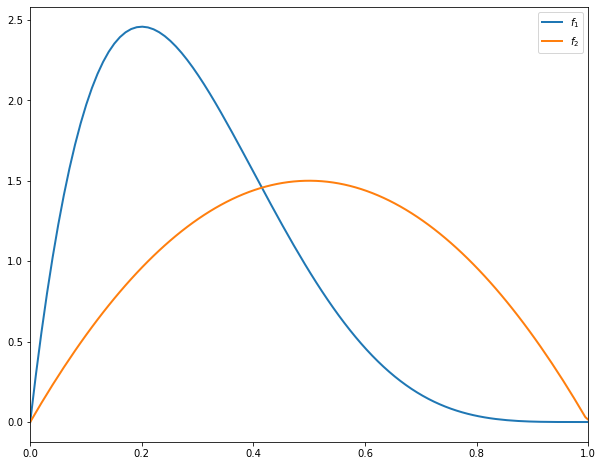

<bound method rv_frozen.pdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016EB4D80CA0>> <bound method rv_frozen.pdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016EB4D95580>>


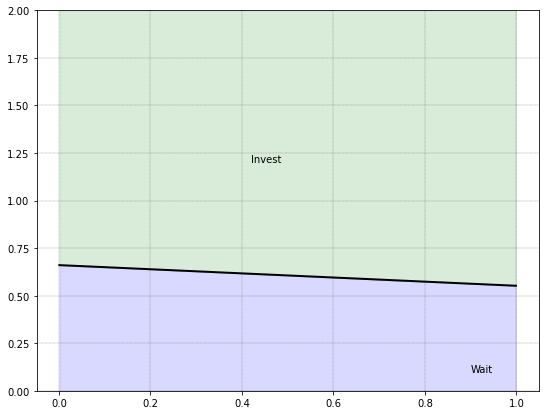

mean of invest time: 1.913 std of invest time: 2.2994414539187558


In [1]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""


import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import LinearNDInterpolator
from scipy.integrate import fixed_quad
from scipy.stats import beta as β_distribution


x = np.linspace(0, 2, 200)
plt.figure(figsize=(10, 8))
plt.plot(x, β_distribution.pdf(x, 2,5, scale=1), label='$f_1$', lw=2)
plt.plot(x, β_distribution.pdf(x,2, 2, scale=1), label='$f_2$', lw=2)
plt.xlim(0, 1)
plt.legend()
plt.show()



β=0.9
I=0.3
z_max=1
z_grid_size=40
mu_grid_size=40
F1 = β_distribution(2, 5, scale=z_max)
F2 = β_distribution(2, 2, scale=z_max)
f1, f2 = F1.pdf, F2.pdf    # Density functions
print(f1,f2)
mu_min, mu_max = 1e-3, 1 - 1e-3  # Avoids instability
s_grid = np.linspace(0, z_max, z_grid_size)
mu_grid = np.linspace(mu_min, mu_max, mu_grid_size)


def q(z, mu):
        new_mu = 1.0 / (1 + ((1 - mu) * f2(z)) / (mu * f1(z)))

        new_mu = np.maximum(np.minimum(new_mu, mu_max), mu_min)

        return new_mu

def res_operator(ξ):
        
        # == Turn ξ into a function == #
        ξ_f = lambda p: np.interp(p, mu_grid, ξ)

        new_ξ = np.empty(len(ξ))
        for i, mu in enumerate(mu_grid):
            def integrand(z):
                "Integral expression on right-hand side of operator"
                return np.maximum(z, ξ_f(q(z, mu))) * (mu * f1(z) + (1 - mu) * f2(z))
            integral, error = fixed_quad(integrand, 0, mu_max)
            new_ξ[i] = (1 - β) * I + β * integral

        return new_ξ
    
ξ = np.ones(len(mu_grid))
ξ_old = ξ
for i in range(10):
    ξ_new = res_operator(ξ_old)
    ξ_old = ξ_new

fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(mu_grid, ξ_new, linewidth=2, color='black')
ax.set_ylim(0, 2)
ax.grid(axis='x', linewidth=0.25, linestyle='--', color='0.25')
ax.grid(axis='y', linewidth=0.25, linestyle='--', color='0.25')
ax.fill_between(mu_grid, 0, ξ_new, color='blue', alpha=0.15)
ax.fill_between(mu_grid, ξ_new, 2, color='green', alpha=0.15)
ax.text(0.42, 1.2, 'Invest')
ax.text(0.9, 0.1, 'Wait')
plt.show()

#simulating the optimal policy for 100 iterations
F_true = β_distribution.pdf(x, 2,2, scale=1)

opt_z = lambda p: np.interp(p, mu_grid, ξ_new)
invest_time=np.empty(1000)
for i in range(1000):
    states = β_distribution.rvs(2,2, scale=1,size=40)
    mu = 0.5
    for j in range(len(states)):
        if states[j]>=opt_z(mu):
            invest_time[i]=j
            break
        else:
            mu = q(states[j],mu)

print("mean of invest time:",np.mean(invest_time),"std of invest time:",np.std(invest_time) )
